# TQQQ Long term strategy

### Entry signal
1. Short term bullish momentum shift
MACD 7-21-15 is bullish and 2-day stochasitic is bullish
2. Short term oversold (Not trending)
3-day RSI below 36


### Exit signal
21-day ADX > 23
MACD 4-47-5 is Bearish

In [14]:
import pandas as pd
import talib
import numpy as np


# Assuming 'filename.csv' is the name of your CSV file
# Adjust the file path as necessary
filename = '../data/TQQQ.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(filename)

# Display the first few rows of the DataFrame
print(data.head())


         Date     Open     High      Low    Close  Adj Close     Volume
0  2019-03-25  13.7650  13.9925  13.5450  13.8500  13.494443  105184800
1  2019-03-26  14.1725  14.4200  13.8275  14.0400  13.679565   87936000
2  2019-03-27  14.0975  14.1950  13.4625  13.7650  13.411627   88405200
3  2019-03-28  13.8675  14.0075  13.6075  13.8525  13.496880   64218800
4  2019-03-29  14.1575  14.2050  13.9200  14.1650  13.801357   63490000


In [27]:

def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculate the Moving Average Convergence Divergence (MACD) for a given stock's historical price data.

    Parameters:
    - data: DataFrame with columns 'Date' (datetime) and 'Close' (float) containing historical price data.
    - fast_period: Integer, optional, default is 12. The time period for the fast EMA.
    - slow_period: Integer, optional, default is 26. The time period for the slow EMA.
    - signal_period: Integer, optional, default is 9. The time period for the signal line (EMA of MACD).

    Returns:
    - DataFrame containing 'Date' (datetime), 'MACD' (float), and 'Signal' (float) columns.
    """
    fast_key = str(fast_period) + 'Fast_EMA'
    slow_key = str(slow_period) + 'Slow_EMA'
    macd_key = str(fast_period) + 'MACD'
    signal_key = str(fast_period) + 'Signal'
    # Calculate the fast and slow EMAs
    data[fast_key] = talib.EMA(data['Close'], timeperiod=fast_period)
    data[slow_key] = talib.EMA(data['Close'], timeperiod=slow_period)

    # Calculate the MACD line
    data[macd_key] = data[fast_key] - data[slow_key]

    # Calculate the signal line (EMA of MACD)
    data[signal_key] = talib.EMA(data[macd_key], timeperiod=signal_period)

    return data[['Date', macd_key, signal_key]]

def calculate_adx(data, period=14):
    """
    Calculate the Average Directional Index (ADX) for a given stock's historical price data.

    Parameters:
    - data: DataFrame with columns 'Date' (datetime), 'High' (float), 'Low' (float), and 'Close' (float)
            containing historical price data.
    - period: Integer, optional, default is 14. The time period for calculating the ADX.

    Returns:
    - DataFrame containing 'Date' (datetime) and 'ADX' (float) columns.
    """
    # Calculate the ADX
    data['ADX'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=period)

    return data[['Date', 'ADX']]
    
def calculate_rsi(data, period=14):
    """
    Calculate the Relative Strength Index (RSI) for a given stock's historical price data.

    Parameters:
    - data: DataFrame with columns 'Date' (datetime) and 'Close' (float) containing historical price data.
    - period: Integer, optional, default is 14. The time period for calculating the RSI.

    Returns:
    - DataFrame containing 'Date' (datetime) and 'RSI' (float) columns.
    """
    # Calculate the RSI
    data['RSI'] = talib.RSI(data['Close'], timeperiod=period)

    return data[['Date', 'RSI']]

def calculate_stoch(data, fastk_period=2, slowk_period=2, slowd_period=2):
    data['Stoch'] = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=2, slowk_period=2, slowd_period=2)[0]

    return data[['Stoch']]
    
def calculate_oversold_rsi(data, period=3, threshold=36):
    """
    Calculate the 3-day Relative Strength Index (RSI) and identify oversold conditions.

    Parameters:
    - data: DataFrame with columns 'Date' (datetime) and 'Close' (float) containing historical price data.
    - period: Integer, optional, default is 3. The time period for calculating the RSI.
    - threshold: Integer, optional, default is 36. The threshold value for identifying oversold conditions.

    Returns:
    - DataFrame containing 'Date' (datetime), 'Close' (float), 'RSI' (float), and 'Oversold' (bool) columns.
    """
    # Calculate the 3-day RSI
    data['RSI'] = talib.RSI(data['Close'], timeperiod=period)
    
    # Identify oversold conditions
    data['Oversold'] = data['RSI'] < threshold
    
    return data[['Date', 'Close', 'RSI', 'Oversold']]

def calculate_buy_signal(data, period=14):
    """
    Short term bullish momentum shift MACD 7-21-15 is bullish and 2-day stochasitic is bullish
    """
    # Generate buy signals
    data['Buy_Signal'] = (data['7MACD'] > data['7Signal']) & (data['Stoch'] > 0) & data['Oversold']
    return data[['Buy_Signal']]
    
def calculate_sell_signal(data, period=14):
    """
    21-day ADX > 23 MACD 4-47-5 is Bearish
    """
    # Calculate the RSI
    data['Sell_Signal'] = (data['ADX'] > 23) & (data['4MACD'] < data['4Signal'])

    return data[['Date', 'RSI']]

def calculate_returns(data, capital=100_000):
    """
    Calculate the returns, Sharpe ratio, and maximum drawdown based on buy and sell signals.

    Parameters:
    - data: DataFrame with columns 'Date' (datetime), 'Open' (float), 'Close' (float),
            'Buy_Signal' (bool), and 'Sell_Signal' (bool) containing historical price data and signals.

    Returns:
    - Tuple containing returns (float), Sharpe ratio (float), and maximum drawdown (float).
    """
    # Initialize variables
    position = None
    quantity = 0
    cash = capital
    last_day_total = capital
    buy_next_open = False
    sell_next_open = False
    peak_value = capital
    
    # Simulate trading
    for index, row in data.iterrows():
        
        if buy_next_open and not sell_next_open:
            buy_next_open = False
            # all in when open
            delta = cash / row['Open']
            quantity = quantity + delta
            cash = cash - delta * row['Open']
            
        if sell_next_open:
            sell_next_open = False
            # sell all stocks
            cash = cash + (quantity * row['Open'])
            quantity = 0

        data.loc[index, 'Cash'] = cash
        stock_value = quantity * row['Close']
        total = cash + quantity * row['Close']
        daliy_pnl = total - last_day_total
        
        data.loc[index, 'Stock_Value'] = stock_value
        data.loc[index, 'Total'] = total
        data.loc[index, 'Daliy_PNL'] = daliy_pnl
        data.loc[index, 'Quantity'] = quantity
        peak_value = max(total, peak_value)
        data.loc[index, 'Dropdown'] = (peak_value - total) / peak_value
        last_day_total = total
            
        if row['Buy_Signal'] and not row['Sell_Signal']:
            buy_next_open = True
        elif row['Sell_Signal']:
            sell_next_open = False

    # Calculate Sharpe ratio
    risk_free_rate = 0.05  # Assume risk-free rate is 0 for simplicity
    daily_rf_rate = (1 + risk_free_rate) ** (1/252) - 1  # Convert annual risk-free rate to daily
    data['Excess_Return'] = (data['Cash'] + data['Stock_Value']) / capital * daily_rf_rate
    print("sqrt: ", np.sqrt(252))
    print("std: ", data['Excess_Return'].std())
    print("excess return", data['Excess_Return'].mean());
    sharpe_ratio = data['Excess_Return'].mean() / (data['Excess_Return'].std() * np.sqrt(252))

    # Calculate maximum drawdown
    max_drawdown = data['Dropdown'].max()
    return sharpe_ratio, max_drawdown
    

In [28]:
calculate_macd(data, 7, 21, 15)
calculate_macd(data, 4, 47, 5)
calculate_adx(data, 21)
calculate_rsi(data, 3)
calculate_stoch(data)
calculate_oversold_rsi(data)

,Date,Close,RSI,Oversold
0,2019-03-25,13.850000,NaN,False
1,2019-03-26,14.040000,NaN,False
2,2019-03-27,13.765000,NaN,False
3,2019-03-28,13.852500,50.226244,False
4,2019-03-29,14.165000,73.072215,False
...,...,...,...,...
1253,2024-03-15,57.759998,22.679317,True
1254,2024-03-18,59.389999,48.282506,False
1255,2024-03-19,59.799999,54.026256,False
1256,2024-03-20,61.700001,74.055506,False


In [29]:
calculate_buy_signal(data)
calculate_sell_signal(data)
data

,Date,Open,High,Low,Close,Adj Close,Volume,7Fast_EMA,21Slow_EMA,7MACD,...,Oversold,Buy_Signal,Sell_Signal,Cash,Stock_Value,Total,Daliy_PNL,Quantity,Dropdown,Excess_Return
0,2019-03-25,13.765000,13.992500,13.545000,13.850000,13.494443,105184800,NaN,NaN,NaN,...,False,False,False,100000.0,0.000000,100000.000000,0.000000,0.00000,0.000000,0.999806
1,2019-03-26,14.172500,14.420000,13.827500,14.040000,13.679565,87936000,NaN,NaN,NaN,...,False,False,False,100000.0,0.000000,100000.000000,0.000000,0.00000,0.000000,0.999806
2,2019-03-27,14.097500,14.195000,13.462500,13.765000,13.411627,88405200,NaN,NaN,NaN,...,False,False,False,100000.0,0.000000,100000.000000,0.000000,0.00000,0.000000,0.999806
3,2019-03-28,13.867500,14.007500,13.607500,13.852500,13.496880,64218800,NaN,NaN,NaN,...,False,False,False,100000.0,0.000000,100000.000000,0.000000,0.00000,0.000000,0.999806
4,2019-03-29,14.157500,14.205000,13.920000,14.165000,13.801357,63490000,NaN,NaN,NaN,...,False,False,False,100000.0,0.000000,100000.000000,0.000000,0.00000,0.000000,0.999806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-03-15,58.689999,58.919998,57.290001,57.759998,57.552334,70270500,59.807438,59.440121,0.367317,...,True,False,False,0.0,377392.995753,377392.995753,-14309.068932,6533.81248,0.347860,3.773736
1254,2024-03-18,59.880001,60.799999,59.290001,59.389999,59.176476,64596900,59.703078,59.435564,0.267514,...,False,False,False,0.0,388043.116629,388043.116629,10650.120876,6533.81248,0.329457,3.880238
1255,2024-03-19,58.540001,59.980000,57.680000,59.799999,59.584999,59405000,59.727308,59.468695,0.258614,...,False,False,False,0.0,390721.979745,390721.979745,2678.863117,6533.81248,0.324828,3.907026
1256,2024-03-20,60.070000,61.830002,59.360001,61.700001,61.700001,78278000,60.220481,59.671541,0.548941,...,False,False,False,0.0,403136.236524,403136.236524,12414.256779,6533.81248,0.303376,4.031169


In [30]:
sharpe, max_dropdown = calculate_returns(data)
print("sharpe ratio = " + str(sharpe))
print("max_dropdown = " + str(max_dropdown))

sqrt:  15.874507866387544
std:  0.0002337180215207833
excess return 0.0004655780158639515
sharpe ratio = 0.12548736312363756
max_dropdown = 0.8175454442813593


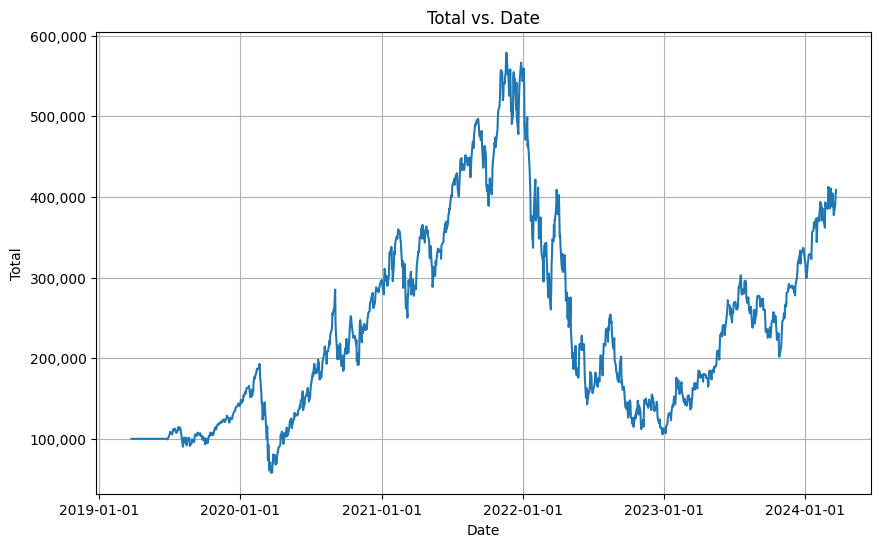

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
from matplotlib.ticker import FuncFormatter


# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data['Date'], data['Total'])
ax.set_xlabel('Date')
ax.set_ylabel('Total')
ax.set_title('Total vs. Date')
ax.grid(True)

ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
# Disable scientific notation for y-axis
def format_yticks(y, _):
    return '{:,.0f}'.format(y)  # Format as integer with commas

ax.yaxis.set_major_formatter(FuncFormatter(format_yticks))


plt.show()

In [173]:
data.to_csv('../output/TQQQLongTermStrategy_Result.csv', index=False)